# Assignment 2: Working with health data from wearables

## Data

In this assigment you will use the [Daily Sports and Activities](http://archive.ics.uci.edu/ml/datasets/Daily+and+Sports+Activities) dataset from the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/index.html). This dataset contains motion sensor data of 19 daily and sports activities (walking, running, rowing, jumping,...), each performed by 8 subjects in their own style for 5 minutes. Five Xsens MTx units are used on the torso, (right and left) arms, and (right and left) legs. 

----

## Objectives

- Understand time-series health data
- Perform pre-processing and visualisation on time-series data
- Extract features from time-series data
- Train a classifier to predict the activity the users are doing

----

## Exercise 1

Load, analyse and visualise the (temporal) data of the different sensors for subject 7 (p7). Compare walking on a treadmill with a speed of 4 km/h on a flat surface (a10) and running on a treadmill with a speed of 8 km/h (a12). Do you see any difference? Comment.
 

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline

In [2]:
temp = pd.read_csv('./data/a01/p7/s01.txt')

In [3]:
path = "./data/"
subject = "/p7/"

data = np.zeros([19, 45, 7500]) # 19 activities, 45 sensor values, x time points

for activity in range(19):
    added_path = path + ("a%02d" % (activity + 1))  + subject
    for f in range(60):
        temp = np.loadtxt(added_path + ("s%02d.txt" % (f + 1)),delimiter=",")
        data[activity,:,f*125:f*125+125] = temp.T

print(data.shape)

(19, 45, 7500)


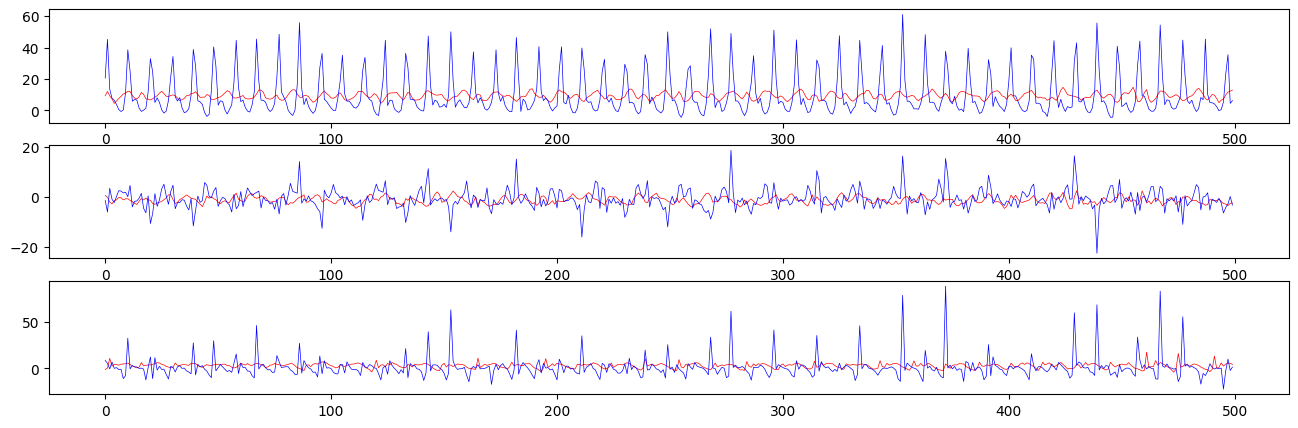

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3,1, figsize=(16,5))

ax[0].plot(data[9,0,:500], linewidth=0.5, c="red")
ax[1].plot(data[9,1,:500], linewidth=0.5, c="red")
ax[2].plot(data[9,2,:500], linewidth=0.5, c="red")

ax[0].plot(data[11,0,:500], linewidth=0.5, c="blue")
ax[1].plot(data[11,1,:500], linewidth=0.5, c="blue")
ax[2].plot(data[11,2,:500], linewidth=0.5, c="blue")

plt.show()

Here we see the accelerometer (x,y,z) of the torso of the given given two activities walking on a treadmill at 4km/h (red) and running on a treadmill with a speed of 8km/h (blue). We see that the more intense activity in blue has more activity on the accelerometer.

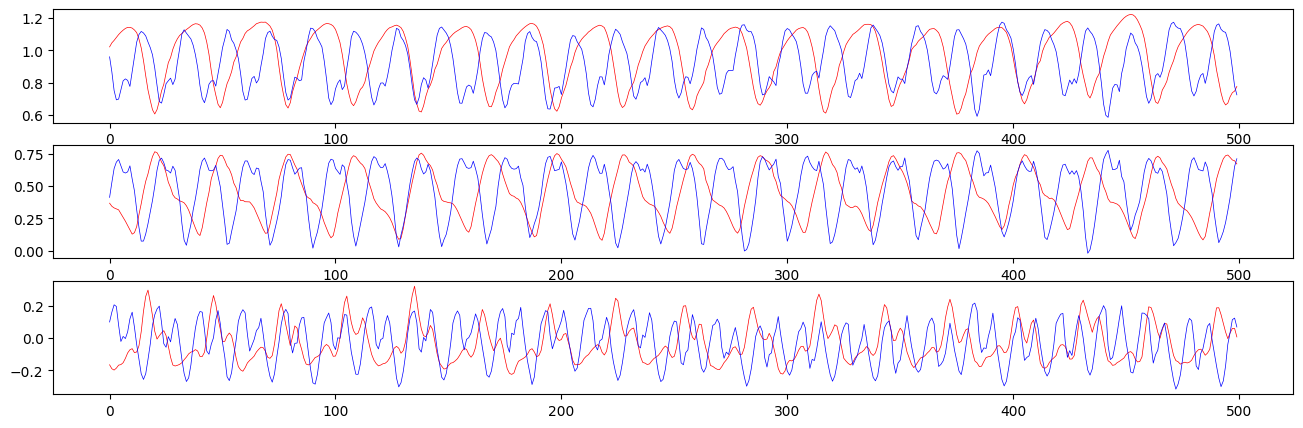

In [5]:
fig, ax = plt.subplots(3,1, figsize=(16,5))

ax[0].plot(data[9,42,:500], linewidth=0.5, c="red")
ax[1].plot(data[9,43,:500], linewidth=0.5, c="red")
ax[2].plot(data[9,44,:500], linewidth=0.5, c="red")

ax[0].plot(data[11,42,:500], linewidth=0.5, c="blue")
ax[1].plot(data[11,43,:500], linewidth=0.5, c="blue")
ax[2].plot(data[11,44,:500], linewidth=0.5, c="blue")

plt.show()

Here we see the magnetometers for the left leg of the same two activities, we see that the frequency of the blue line is almost double the speed the red, as it should being double the speed of the treadmill.

## Exercise 2

Build a model (classifier) to predict the activity of a given subject. Decide on which features could be extracted from the data. For example:

- **mean, variance,skewness, and the kurtosis**. The distribution of each signal are approximately Normal. This means that we can take the first four statistical moments for each 5 second segment. By including the four moments, we are helping our models better learn the characteristic of each unique activity. 
- n first values of the  the  [**autocorrelation**](https://en.wikipedia.org/wiki/Autocorrelation) sequence. In some time series analyses, such as in [ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average), it is desirable to minimize autocorrelation so as to transform the series into a [stationary state](https://en.wikipedia.org/wiki/Stationary_process). 
- n peaks of the [**discrete Fourier transform**](https://en.wikipedia.org/wiki/Discrete_Fourier_transform)
of a segment with the corresponding frequencies.

Consider normalising all features between [0,1] and reduce the dimension of features using [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis).


We propose 2 approaches to create your train/testing set.

(1) Train and test sets that contain shuffled samples from each user. So the model will train on data from every user and predict the activities from every user in the test set.
(2) Seven user's data will be used as the training set and only one user's data as the test set. The goal here is to predict the activities of a user that the model has never seen before. How good is the model generalising the problem?

For each approach, consider the following building framework:
1. Split data into train and holdout sets
2. Optimize model hyperparameters
3. Cross Validate model's performance by analyze learning curves

Finally, consider the follwing evaluation metrics:

**Accuracy** represents how close or far off a given set of measurements are to their true value.

**Precision**: percentage of classifications predicted to be positive are actually positive. **Precision is a measure of the failure to correctly predict positive classifications. **

$$\textbf{Precision} = \frac{TP}{TP + FP}, $$

where TP refers to True Positives and FP to False Positives. 

**Recall** describes how well the model can identify points that belong to the positive class. **Recall is a measure of the failure in distinguishing between positive and negative classifications. **

$$\textbf{Recall} = \frac{TP}{TP + FN},$$

where FN corresponds to False Negatives.

Finally, the $f_{1} score$ is a weighted average of precision and recall. The  $f_{1} score$  is used to get a measure of both types of failures.

**Note: Make comments on the code to discuss the results.**
 

In [7]:
path = "./data/"

data = np.zeros([19, 8, 45, 7500]) # 19 activities, 8 subjects, 45 sensor values, x time points

for activity in range(19):
    for subject in range(8):
        added_path = path + ("a%02d" % (activity + 1))  + ("/p%01d/" % (subject + 1))
        for f in range(60):
            temp = np.loadtxt(added_path + ("s%02d.txt" % (f + 1)),delimiter=",")
            data[activity,subject,:,f*125:f*125+125] = temp.T

print(data.shape)

(19, 8, 45, 7500)


In [8]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size // 2:]

In [12]:
from scipy.stats import skew, kurtosis
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks
n_features = 12

processed_data = np.zeros([19, 8, 60, 45, n_features]) # 19 activities, 8 subjects, 60 segments, 45 sensor values, n_features

for activity in range(19):
    print("Activity %02d..."%(activity+1))
    for subject in range(8):
        print("\tSubject %02d..."%(subject+1))
        for sensor in range(45):
            for si in range(60):
                segment = data[activity, subject, sensor, si*125:si*125+125]
                a_corr = autocorr(segment)

                # raw waveform features
                processed_data[activity, subject, si, sensor, 0] = np.mean(segment)     # Mean feature
                processed_data[activity, subject, si, sensor, 1] = np.var(segment)      # Variance feature
                processed_data[activity, subject, si, sensor, 2] = skew(segment)        # Skweness feature
                processed_data[activity, subject, si, sensor, 3] = kurtosis(segment)    # Kurtosis feature

                # autocorrelation features
                processed_data[activity, subject, si, sensor, 4] = np.mean(a_corr)     # Mean feature
                processed_data[activity, subject, si, sensor, 5] = np.var(a_corr)      # Variance feature
                processed_data[activity, subject, si, sensor, 6] = skew(a_corr)        # Skweness feature
                processed_data[activity, subject, si, sensor, 7] = kurtosis(a_corr)    # Kurtosis feature

                # FFT Peaks, we take the top 4 peaks
                yf = fft(segment, norm='forward')
                n = 125
                freq = fftfreq(n, d=1/25)

                height_threshold=0.01

                peaks_index, properties = find_peaks(np.abs(yf), height=height_threshold)
                
                linds = properties['peak_heights'].argsort()
                peaks_index = peaks_index[linds[::-1]]
                
                for pi in range(4):
                    if pi < len(peaks_index):
                        processed_data[activity, subject, si, sensor, 8+pi] = peaks_index[pi]
                    else:
                        processed_data[activity, subject, si, sensor, 8+pi] = 0.0
                

print(processed_data.shape)

Activity 01...
	Subject 01...
	Subject 02...
	Subject 03...
	Subject 04...
	Subject 05...
	Subject 06...
	Subject 07...
	Subject 08...
Activity 02...
	Subject 01...
	Subject 02...
	Subject 03...
	Subject 04...
	Subject 05...
	Subject 06...
	Subject 07...
	Subject 08...
Activity 03...
	Subject 01...
	Subject 02...
	Subject 03...
	Subject 04...
	Subject 05...
	Subject 06...
	Subject 07...
	Subject 08...
Activity 04...
	Subject 01...
	Subject 02...
	Subject 03...
	Subject 04...
	Subject 05...
	Subject 06...
	Subject 07...
	Subject 08...
Activity 05...
	Subject 01...
	Subject 02...
	Subject 03...
	Subject 04...
	Subject 05...
	Subject 06...
	Subject 07...
	Subject 08...
Activity 06...
	Subject 01...
	Subject 02...
	Subject 03...
	Subject 04...
	Subject 05...
	Subject 06...
	Subject 07...
	Subject 08...
Activity 07...
	Subject 01...
	Subject 02...
	Subject 03...
	Subject 04...
	Subject 05...
	Subject 06...
	Subject 07...
	Subject 08...
Activity 08...
	Subject 01...
	Subject 02...
	Subject 0

In [13]:
processed_data = processed_data.reshape((19, 8, 60, 45*n_features))
processed_data.shape

(19, 8, 60, 540)

### Approach 1


In [14]:
data_1 = processed_data.reshape((19*8*60, 45*n_features))
labels_1 = np.array([i//(60*8) for i in range(19*60*8)])

print(data_1.shape)
print(labels_1.shape)

(9120, 540)
(9120,)


In [15]:
from sklearn.decomposition import PCA
pca = PCA()
data_t = pca.fit_transform(data_1)[:,:128]
print(data_t.shape)

(9120, 128)


In [16]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(data_1, labels_1, test_size=0.33, random_state=42)

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.979734219269103


In [17]:
cfn_matrix = metrics.confusion_matrix(y_test, y_pred)

FP = cfn_matrix.sum(axis=0) - np.diag(cfn_matrix)  
FN = cfn_matrix.sum(axis=1) - np.diag(cfn_matrix)
TP = np.diag(cfn_matrix)
TN = cfn_matrix.sum() - (FP + FN + TP)

precision = TP/(TP+FP)
recall = TP/(TP+FN)

f1_score = (2 * precision * recall) / (precision + recall)

for i in range(cfn_matrix.shape[0]):
    print("Class %d metrics:" % (i+1))
    print("\tPrecision %02f" % precision[i])
    print("\tRecall %02f" % recall[i])
    print("\tF1 Score %02f" % f1_score[i])

Class 1 metrics:
	Precision 1.000000
	Recall 0.970930
	F1 Score 0.985251
Class 2 metrics:
	Precision 0.966667
	Recall 0.986395
	F1 Score 0.976431
Class 3 metrics:
	Precision 1.000000
	Recall 0.982857
	F1 Score 0.991354
Class 4 metrics:
	Precision 1.000000
	Recall 0.994118
	F1 Score 0.997050
Class 5 metrics:
	Precision 1.000000
	Recall 1.000000
	F1 Score 1.000000
Class 6 metrics:
	Precision 0.993103
	Recall 1.000000
	F1 Score 0.996540
Class 7 metrics:
	Precision 0.938272
	Recall 0.878613
	F1 Score 0.907463
Class 8 metrics:
	Precision 0.849673
	Recall 0.896552
	F1 Score 0.872483
Class 9 metrics:
	Precision 1.000000
	Recall 1.000000
	F1 Score 1.000000
Class 10 metrics:
	Precision 1.000000
	Recall 1.000000
	F1 Score 1.000000
Class 11 metrics:
	Precision 1.000000
	Recall 0.987261
	F1 Score 0.993590
Class 12 metrics:
	Precision 1.000000
	Recall 1.000000
	F1 Score 1.000000
Class 13 metrics:
	Precision 1.000000
	Recall 0.987421
	F1 Score 0.993671
Class 14 metrics:
	Precision 1.000000
	Recall 1

In [20]:
from sklearn.model_selection import ShuffleSplit

cfn_matrix = np.zeros((19, 19))
ss = ShuffleSplit(n_splits=10, test_size=0.33, random_state=42)

c = 0

for train_index, test_index in ss.split(data_1):
    X_train, X_test, y_train, y_test = data_1[train_index], data_1[test_index], labels_1[train_index], labels_1[test_index]
    clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    c+=1
    print("Model %d Accuracy:" % c,metrics.accuracy_score(y_test, y_pred))
    cfn_matrix = cfn_matrix + metrics.confusion_matrix(y_test, y_pred)


FP = cfn_matrix.sum(axis=0) - np.diag(cfn_matrix)  
FN = cfn_matrix.sum(axis=1) - np.diag(cfn_matrix)
TP = np.diag(cfn_matrix)
TN = cfn_matrix.sum() - (FP + FN + TP)

precision = TP/(TP+FP)
recall = TP/(TP+FN)

f1_score = (2 * precision * recall) / (precision + recall)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

for i in range(cfn_matrix.shape[0]):
    print("Class %d metrics:" % (i+1))
    print("\tPrecision %02f" % precision[i])
    print("\tRecall %02f" % recall[i])
    print("\tF1 Score %02f" % f1_score[i])

Model 1 Accuracy: 0.979734219269103
Model 2 Accuracy: 0.9787375415282392
Model 3 Accuracy: 0.9813953488372092
Model 4 Accuracy: 0.9813953488372092
Model 5 Accuracy: 0.9770764119601328
Model 6 Accuracy: 0.9780730897009967
Model 7 Accuracy: 0.9813953488372092
Model 8 Accuracy: 0.973421926910299
Model 9 Accuracy: 0.9830564784053156
Model 10 Accuracy: 0.9800664451827242
Accuracy: 0.9800664451827242
Class 1 metrics:
	Precision 1.000000
	Recall 0.978056
	F1 Score 0.988906
Class 2 metrics:
	Precision 0.968909
	Recall 0.978219
	F1 Score 0.973542
Class 3 metrics:
	Precision 1.000000
	Recall 0.982423
	F1 Score 0.991134
Class 4 metrics:
	Precision 1.000000
	Recall 0.994406
	F1 Score 0.997195
Class 5 metrics:
	Precision 1.000000
	Recall 0.997473
	F1 Score 0.998735
Class 6 metrics:
	Precision 0.995553
	Recall 0.994289
	F1 Score 0.994921
Class 7 metrics:
	Precision 0.889618
	Recall 0.911927
	F1 Score 0.900634
Class 8 metrics:
	Precision 0.874016
	Recall 0.850032
	F1 Score 0.861857
Class 9 metrics:
	

Here we see that the classifier is pretty good at classifying the different activities with all the information available, at around 98% accuracy in a shuffled KFold crossvalidation with 10 folds. I tested the PCA to see if the accuracy was better, but it didn't improve and got worse at times, at best the accuracy matched the classifier with a high number of components. I used a pipeline with a Standard Scaler to normalize the features and an SVM to classify them.

### Approach 2


In [183]:
X_train = processed_data[:,6,:,:].reshape((19*60, 45*n_features)) # take only 7th subject data
y_train = np.array([i//(60) for i in range(19*60)])

print(X_train.shape)
print(y_train.shape)

X_test = np.delete(processed_data, 6, axis=1).reshape((19*60*7, 45*n_features)) 
y_test = np.array([i//(60*7) for i in range(19*60*7)])
print(X_test.shape)
print(y_train.shape)

(1140, 540)
(1140,)
(7980, 540)
(1140,)


In [184]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6478696741854637


In [185]:
cfn_matrix = metrics.confusion_matrix(y_test, y_pred)
cfn_matrix.shape

FP = cfn_matrix.sum(axis=0) - np.diag(cfn_matrix)  
FN = cfn_matrix.sum(axis=1) - np.diag(cfn_matrix)
TP = np.diag(cfn_matrix)
TN = cfn_matrix.sum() - (FP + FN + TP)

precision = TP/(TP+FP)
recall = TP/(TP+FN)

f1_score = (2 * precision * recall) / (precision + recall)

for i in range(cfn_matrix.shape[0]):
    print("Class %d metrics:" % (i+1))
    print("\tPrecision %02f" % precision[i])
    print("\tRecall %02f" % recall[i])
    print("\tF1 Score %02f" % f1_score[i])

Class 1 metrics:
	Precision 0.995370
	Recall 0.511905
	F1 Score 0.676101
Class 2 metrics:
	Precision 0.832061
	Recall 0.778571
	F1 Score 0.804428
Class 3 metrics:
	Precision 0.839080
	Recall 0.695238
	F1 Score 0.760417
Class 4 metrics:
	Precision 1.000000
	Recall 0.669048
	F1 Score 0.801712
Class 5 metrics:
	Precision 0.511194
	Recall 0.978571
	F1 Score 0.671569
Class 6 metrics:
	Precision 0.959375
	Recall 0.730952
	F1 Score 0.829730
Class 7 metrics:
	Precision 0.404223
	Recall 0.638095
	F1 Score 0.494922
Class 8 metrics:
	Precision 0.260838
	Recall 0.845238
	F1 Score 0.398652
Class 9 metrics:
	Precision 0.986301
	Recall 0.685714
	F1 Score 0.808989
Class 10 metrics:
	Precision 0.786260
	Recall 0.245238
	F1 Score 0.373866
Class 11 metrics:
	Precision 0.655022
	Recall 0.357143
	F1 Score 0.462250
Class 12 metrics:
	Precision 1.000000
	Recall 0.028571
	F1 Score 0.055556
Class 13 metrics:
	Precision 0.973684
	Recall 0.792857
	F1 Score 0.874016
Class 14 metrics:
	Precision 0.989362
	Recall 0

Here the classifier performs worse than the first approach, as the different subjects each have a different style of doing the given activity. Nonetheless, the classifier has an accuracy of around 65%, better than random chance at 5.2%.